In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")

paraphrase_tokenizer = AutoTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
paraphrase_model = AutoModelForSeq2SeqLM.from_pretrained("tuner007/pegasus_paraphrase")

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

tokenizer.pad_token = tokenizer.eos_token

def generate_response(prompt):
    # Tokenize input and add attention mask
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    
    # Generate output
    outputs = model.generate(
        inputs["input_ids"], 
        attention_mask=inputs["attention_mask"], 
        max_length=200,                
        temperature=0.7,          
        top_k=50,                     
        top_p=0.9,                    
        repetition_penalty=1.2,       
        no_repeat_ngram_size=3,    
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,  
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    if not response.endswith(('.', '!', '?')):
        response += '...'
    
    return response

prompt = "girl, this is crazy"

print(generate_response(prompt))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or u

girl, this is crazy." "I'm not crazy." "(SIGHS)" "I know." "You're not crazy, either." "But you're not a girl." "And you're a girl who's been through a lot." "So I'm gonna tell you something." "If you ever want to talk about it, you can." "Okay?" "But I'm not gonna tell anyone." "Not even my parents." "They're not gonna know." "(CHUCKLES)" "Okay." "Well, I'm sorry." "It's just..." "I don't know." "'Cause I'm a girl, and I'm scared." "Yeah." "Me, too." "Hey, you know what?" "I think I'm going to go to the bathroom." "Oh, no, no." "No, no!" "No!" "I'll be right back." "What?" "No." "Don't go." "Please don't go...


In [3]:
import torch

def get_confidence(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        return_dict_in_generate=True,
        output_scores=True,  # Return scores
    )
    scores = torch.stack(outputs.scores, dim=0)
    probs = torch.nn.functional.softmax(scores, dim=-1)
    confidences = probs.max(dim=-1).values
    average_confidence = confidences.mean().item()
    return average_confidence


In [4]:
def get_entropy(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        return_dict_in_generate=True,
        output_scores=True,
    )
    scores = torch.stack(outputs.scores, dim=0)
    probs = torch.nn.functional.softmax(scores, dim=-1)
    entropies = -(probs * torch.log(probs + 1e-9)).sum(dim=-1)
    average_entropy = entropies.mean().item()
    return average_entropy


In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def qa_reversibility(prompt, response):
    # Reverse the response back to a question
    reverse_prompt = f"Based on this answer, what was the question: {response}"
    reverse_response = generate_response(reverse_prompt)
    
    # Compare embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model
    embeddings = model.encode([prompt, reverse_response])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity


In [6]:
def generate_paraphrases(question, num_paraphrases=5):
    inputs = paraphrase_tokenizer([question], truncation=True, padding=True, return_tensors="pt", max_length=60)
    outputs = paraphrase_model.generate(
        inputs["input_ids"], 
        max_length=60, 
        num_return_sequences=num_paraphrases, 
        num_beams=num_paraphrases
    )
    return [paraphrase_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

def generate_responses(prompts):
    responses = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
        outputs = model.generate(inputs["input_ids"], max_length=100, temperature=0.7)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        responses.append(response)
    return responses

def calculate_variance(question):
    paraphrases = generate_paraphrases(question)
    responses = generate_responses(paraphrases)
    embeddings = embedding_model.encode(responses)
    similarity_matrix = cosine_similarity(embeddings, embeddings)
    
    upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
    variances = np.var(similarity_matrix[upper_triangle_indices])
    
    return {
        "paraphrases": paraphrases,
        "responses": responses,
        "variance": variances
    }


In [26]:
import matplotlib.pyplot as plt


def track_token_dynamics(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    input_ids = inputs["input_ids"]
    num_tokens = input_ids.shape[1]
    
    # Store metrics for each token
    token_probabilities = []
    entropies = []
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Process tokens one by one
    for i in range(1, num_tokens):
        partial_input_ids = input_ids[:, :i]
        target_token = input_ids[:, i]
        
        with torch.no_grad():
            outputs = model(input_ids=partial_input_ids)
            logits = outputs.logits[:, -1, :]  # Logits for the last token
            probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
            
            # Track the probability of the true token
            true_token_prob = probs[target_token.item()]
            token_probabilities.append(true_token_prob)
            
            # Calculate entropy of the distribution
            entropy = -np.sum(probs * np.log(probs + 1e-12))  # Add small value for numerical stability
            entropies.append(entropy)
    
    # Exclude the first token as it's not evaluated
    tokens = tokens[1:]
    
    return tokens, token_probabilities, entropies

def plot_token_influence(tokens, probabilities, entropies):
    x = list(range(len(tokens)))
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot true token probabilities
    ax1.plot(x, probabilities, 'b-o', label='True Token Probability')
    ax1.set_xlabel('Token Index')
    ax1.set_ylabel('True Token Probability', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Add token labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
    
    # Plot entropy on a secondary axis
    ax2 = ax1.twinx()
    ax2.plot(x, entropies, 'r--s', label='Entropy')
    ax2.set_ylabel('Entropy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add a title and legend
    plt.title("Token Influence on Model Predictions")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


In [19]:
get_confidence(prompt)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0.6158612370491028

In [4]:
qa_reversibility(prompt, generate_response(prompt))

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


0.5304874

In [11]:
para_variance = calculate_variance(prompt)

print("\nResponse Variance:", para_variance["variance"])


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` 


Response Variance: 0.0055738227


girl, this is crazy


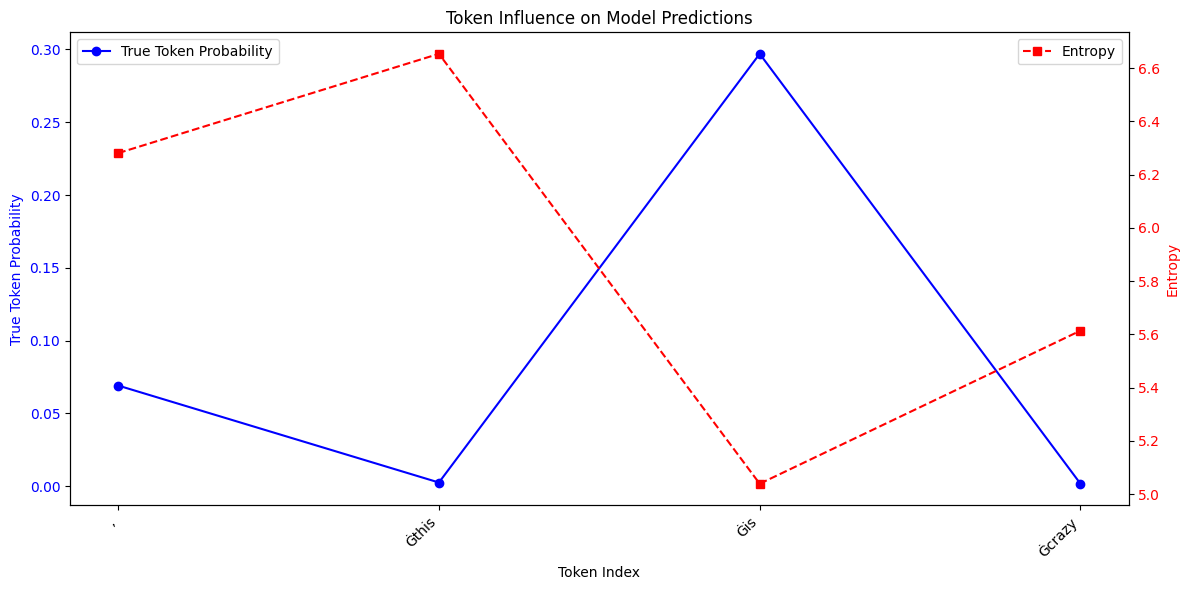

In [29]:
print(prompt)
tokens, probabilities, entropies = track_token_dynamics(prompt)

plot_token_influence(tokens, probabilities, entropies)
